In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Calculate function

In [2]:
def find_midpoint(x, y, w, h):
    return (x+w//2, y+h//2)

In [3]:
def is_front(width, height, x, y, w, h):
    if x < width < x+w and y < height < y+h:
        return True
    return False

In [4]:
def find_direction(width, height, posx, posy):
    ptx = width//3
    pty = height//3

    dx = -1
    dy = -1

    if 0 <= posx <= ptx:
        dx = 0
    elif ptx < posx < ptx*2:
        dx = 1
    else:
        dx = 2
    
    if 0 <= posy <= pty:
        dy = 0
    elif pty < posy < pty*2:
        dy = 1
    else:
        dy = 2

    return (dx, dy)

In [5]:
POSITION_MATRIX = [[set(), set(), set()],
                   [set(), set(), set()],
                   [set(), set(), set()]]
CHANGES_MATRIX = [[set(), set(), set()],
                  [set(), set(), set()],
                  [set(), set(), set()]]

### Class Lables

In [6]:
coco_classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", 
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", 
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", 
    "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", 
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", 
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", 
    "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", 
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", 
    "potted plant", "bed", "dining table", "toilet", "TV", "laptop", "mouse", 
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", 
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", 
    "hair drier", "toothbrush"
]

### Load Image

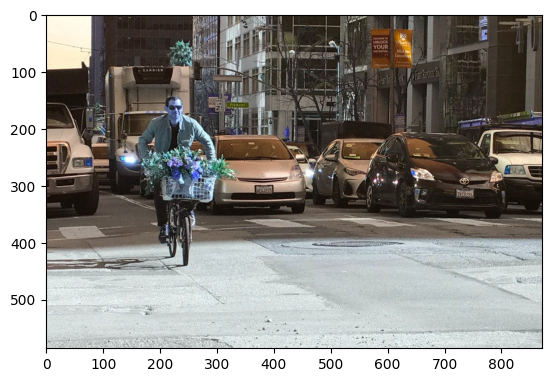

In [7]:
image = cv2.imread('.\\testdata\\yolo\\yolo_test1.jpg')
res = image.copy()
height, width, channels = image.shape
plt.imshow(image)

### Load model

In [8]:
net = cv2.dnn.readNet('.\\yolo_data\\yolov3-tiny.weights', '.\\yolo_data\\yolov3-tiny.cfg')
layer_names = net.getLayerNames()
output_layer_indices = net.getUnconnectedOutLayers()
if isinstance(output_layer_indices, int):
    output_layer_indices = [output_layer_indices]
output_layers = [layer_names[i - 1] for i in output_layer_indices]

### Load deep neural network and blob object, Detect Object

In [9]:
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

### Detected data organize

In [10]:
boxes = []
class_ids = []
confidences = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)

            d_w = int(detection[2] * width)
            d_h = int(detection[3] * height)
            d_x = int(center_x - d_w / 2)
            d_y = int(center_y - d_h / 2)

            boxes.append([d_x, d_y, d_w, d_h])
            class_ids.append(class_id)
            confidences.append(float(confidence))

### Draw detected object

In [11]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
cv2.circle(res, (width//2, height//2), 30, (0,0,255), 3)
for i in range(len(boxes)):
    if i in indexes:
        r_x, r_y, r_w, r_h = boxes[i]
        class_id_num = class_ids[i]
        class_id_name = coco_classes[class_id_num]
        cv2.rectangle(res, (r_x, r_y), (r_x + r_w, r_y + r_h), (0,255,0), 2)
        cv2.putText(res, class_id_name, (r_x, r_y-5), cv2.FONT_ITALIC, 0.5, (0,255,0), 2)
        cv2.line(res, (width//2, height//2), find_midpoint(r_x, r_y, r_w, r_h), (255,0,0), 1)
        cv2.circle(res, find_midpoint(r_x, r_y, r_w, r_h), 5, (0,255,0), -1)

In [12]:
for i in range(len(boxes)):
    if i in indexes:
        r_x, r_y, r_w, r_h = boxes[i]
        class_id_num = class_ids[i]
        class_id_name = coco_classes[class_id_num]
        m_x, m_y = find_midpoint(r_x, r_y, r_w, r_h)

        px, py = find_direction(width, height, m_x, m_y)
        CHANGES_MATRIX[py][px].add(class_id_name)

        print(class_id_name, px,py)

person 0 1
car 1 1
car 1 1
car 2 1
car 2 1
car 1 1


In [23]:
position_names = [['left top', 'top', 'right top'],
                  ['left', 'front', 'right'],
                  ['left bottom', 'bottom', 'right bottom']]
changes_log = ''
for i in range(3):
    for j in range(3):
        change = CHANGES_MATRIX[i][j].difference(POSITION_MATRIX[i][j])

        if len(change) < 1:
            continue
        changes_log += str(*change) + ' ' + position_names[i][j] + '. '
        print(*change,len(change))

        POSITION_MATRIX[i][j] = CHANGES_MATRIX[i][j].copy()

CHANGES_MATRIX = [[set(), set(), set()],
                  [set(), set(), set()],
                  [set(), set(), set()]]
print(changes_log)
print(POSITION_MATRIX)


person 1
car 1
car 1
person left. car front. car right. 
[[set(), set(), set()], [{'person'}, {'car'}, {'car'}], [set(), set(), set()]]


### Result

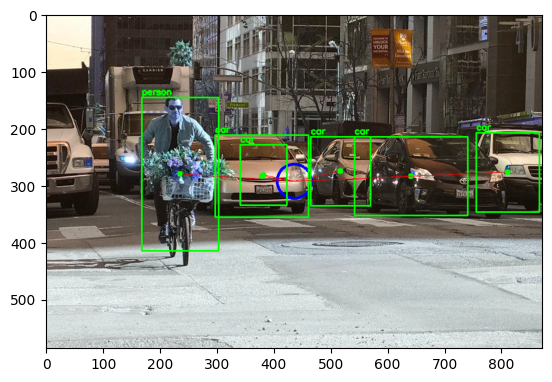

In [13]:
plt.imshow(res)